In [94]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../")

from cfmining.algorithms import MAPOFCEM
from cfmining.predictors import MonotoneClassifier
from cfmining.baselines import MAPOCAM

from experiments_helper import get_data_model, run_experiments, format_df_table, summarize_results, get_action_set


%load_ext autoreload
%autoreload 2

SEED = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
max_changes = 3
objective = "abs_diff"
for dataset_name in [
    "german", 
    "taiwan",
    "adult"
    ]:
    dataset, X_train, Y_train, model, outlier_detection, individuals = get_data_model(dataset_name, "LogisticRegression")
    individuals = individuals.sample(n = 50, random_state=SEED)
    outlier_detection.contamination = dataset.outlier_contamination
    action_set = get_action_set(dataset, X_train, default_step_size=0.05)

    model = MonotoneClassifier(model, outlier_detection, X = X_train)

    method = MAPOFCEM(
        action_set = action_set,
        classifier = model,
        compare = objective,
        max_changes = max_changes,
        outlier_contamination= dataset.outlier_contamination,
        estimate_outlier=True,
        time_limit=np.inf,
    )

    run_experiments(
        method,
        individuals=individuals,
        model=model,
        output_file=f"../results/lr/{dataset}/mapofcem_{objective}.csv"
    );

    # ablation without outlier estimation

    method = MAPOFCEM(
        action_set = action_set,
        classifier = model,
        compare = objective,
        max_changes = max_changes,
        outlier_contamination= dataset.outlier_contamination,
        estimate_outlier=False,
        time_limit=np.inf,
    )

    run_experiments(
        method,
        individuals=individuals,
        model=model,
        output_file=f"../results/lr/{dataset}/mapofcem_ablation_{objective}.csv"
    );



    for feat in action_set:
        feat.flip_direction = 1
        feat.update_grid()
    
    method = MAPOCAM(
        action_set,
        model,
        criteria = objective,
        max_changes=max_changes
    )

    run_experiments(
        method,
        individuals=individuals,
        model=model,
        output_file=f"../results/lr/{dataset}/mapocam_{objective}.csv"
    );

PermutationExplainer explainer: 101it [00:12,  1.42it/s]                                                                                                                                                 
 42%|████████████████████████████████████████████████████████████████████▉                                                                                               | 21/50 [06:06<10:39, 22.05s/it]

In [127]:
method_list = ["mapofcem_abs_diff", "mapofcem_ablation_abs_diff", "mapocam_abs_diff"]

In [128]:
def show_results(dataset_name, method_list):
    results = []
    for method in method_list:
        results_cur = pd.read_csv(f"../results/lr/{dataset_name}/{method}.csv")
        results_cur = summarize_results(results_cur, dataset_name)
        results_cur["method"] = method
        results.append(results_cur)
    results = pd.concat(results)
    return format_df_table(results, "method", results.columns.tolist()[:-1])

In [129]:
show_results("german", method_list)

,method,percentile_costs,lp_costs,max_dist_costs,abs_diff_costs,n_changes,outlier,diversity,n_solutions,time
0,mapocam_abs_diff,0.365 (+-0.226) | 0.796,1.917 (+-1.404) | 4.458,1.703 (+-1.161) | 3.383,0.093 (+-0.081) | 0.247,1.755 (+-0.693) | 3.0,0.0 (+-0.0) | 0.0,0.0 (+-0.0) | 0.0,0.98 (+-0.141) | 1.0,15.724 (+-13.575) | 42.051
1,mapofcem_ablation_abs_diff,0.362 (+-0.228) | 0.796,1.928 (+-1.408) | 4.458,1.726 (+-1.176) | 3.383,0.093 (+-0.081) | 0.247,1.755 (+-0.723) | 3.0,0.0 (+-0.0) | 0.0,0.0 (+-0.0) | 0.0,0.98 (+-0.141) | 1.0,15.994 (+-13.631) | 42.587
2,mapofcem_abs_diff,0.362 (+-0.228) | 0.796,1.928 (+-1.408) | 4.458,1.726 (+-1.176) | 3.383,0.093 (+-0.081) | 0.247,1.755 (+-0.723) | 3.0,0.0 (+-0.0) | 0.0,0.0 (+-0.0) | 0.0,0.98 (+-0.141) | 1.0,16.252 (+-14.047) | 42.995


In [130]:
show_results("taiwan", method_list)

,method,percentile_costs,lp_costs,max_dist_costs,abs_diff_costs,n_changes,outlier,diversity,n_solutions,time
0,mapocam_abs_diff,0.333 (+-0.099) | 0.486,2.366 (+-0.904) | 3.879,2.162 (+-0.799) | 3.581,0.274 (+-0.12) | 0.469,2.04 (+-0.605) | 3.0,0.08 (+-0.274) | 1.0,0.0 (+-0.0) | 0.0,1.0 (+-0.0) | 1.0,58.739 (+-51.805) | 136.343
1,mapofcem_ablation_abs_diff,0.335 (+-0.095) | 0.486,2.354 (+-0.879) | 3.879,2.136 (+-0.763) | 3.581,0.276 (+-0.119) | 0.469,2.1 (+-0.647) | 3.0,0.06 (+-0.24) | 0.55,0.0 (+-0.0) | 0.0,1.0 (+-0.0) | 1.0,55.933 (+-49.201) | 130.763
2,mapofcem_abs_diff,0.335 (+-0.095) | 0.486,2.354 (+-0.879) | 3.879,2.136 (+-0.763) | 3.581,0.276 (+-0.119) | 0.469,2.1 (+-0.647) | 3.0,0.06 (+-0.24) | 0.55,0.0 (+-0.0) | 0.0,1.0 (+-0.0) | 1.0,51.733 (+-77.074) | 110.712


In [131]:
show_results("adult", method_list)

,method,percentile_costs,lp_costs,max_dist_costs,abs_diff_costs,n_changes,outlier,diversity,n_solutions,time
0,mapocam_abs_diff,0.796 (+-0.151) | 0.876,1.102 (+-0.524) | 1.695,1.102 (+-0.524) | 1.695,0.138 (+-0.066) | 0.212,1.0 (+-0.0) | 1.0,0.16 (+-0.37) | 1.0,0.0 (+-0.0) | 0.0,1.0 (+-0.0) | 1.0,1.274 (+-0.781) | 2.555
1,mapofcem_ablation_abs_diff,0.762 (+-0.171) | 0.874,1.308 (+-0.769) | 2.406,1.254 (+-0.655) | 2.003,0.183 (+-0.145) | 0.417,1.26 (+-0.565) | 2.55,0.06 (+-0.24) | 0.55,0.0 (+-0.0) | 0.0,1.0 (+-0.0) | 1.0,3.884 (+-7.958) | 15.599
2,mapofcem_abs_diff,0.764 (+-0.166) | 0.874,1.268 (+-0.668) | 2.296,1.24 (+-0.632) | 2.003,0.171 (+-0.107) | 0.404,1.245 (+-0.56) | 2.6,0.02 (+-0.143) | 0.0,0.0 (+-0.0) | 0.0,0.98 (+-0.141) | 1.0,2.357 (+-3.088) | 6.134


In [50]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from ast import literal_eval

In [81]:
dataset_name = "adult"
dataset, X_train, Y_train, model, outlier_detection, individuals = get_data_model(dataset_name, "LogisticRegression")
individuals = individuals.sample(n = 50, random_state=SEED)

In [88]:
results_mapofcem = pd.read_csv(f"../results/lr/{dataset_name}/mapofcem_abs_diff.csv")
mapofcem_solutions = []
for i, row in results_mapofcem.iterrows():
    ind = literal_eval(row["individual"])
    solutions = literal_eval(row["solutions"])
    if len(solutions) > 0:
        mapofcem_solutions.append(solutions[0])
    else:
        mapofcem_solutions.append(ind)
mapofcem_solutions = np.array(mapofcem_solutions)
mapofcem_solutions = pd.DataFrame(mapofcem_solutions, columns = X_train.columns)

In [90]:
results_mapocam = pd.read_csv(f"../results/lr/{dataset_name}/mapocam_abs_diff.csv")
mapocam_solutions = []
for i, row in results_mapocam.iterrows():
    ind = literal_eval(row["individual"])
    solutions = literal_eval(row["solutions"])
    if len(solutions) > 0:
        mapocam_solutions.append(solutions[0])
    else:
        mapocam_solutions.append(ind)
mapocam_solutions = np.array(mapocam_solutions)
mapocam_solutions = pd.DataFrame(mapocam_solutions, columns = X_train.columns)

In [91]:
pca = PCA(n_components=2).fit(model[:-1].transform(X_train))
X_train_prep = pca.transform(model[:-1].transform(X_train))
individuals_prep = pca.transform(model[:-1].transform(individuals))
mapocam_solutions_prep = pca.transform(model[:-1].transform(mapocam_solutions))
mapofcem_solutions_prep = pca.transform(model[:-1].transform(mapofcem_solutions))

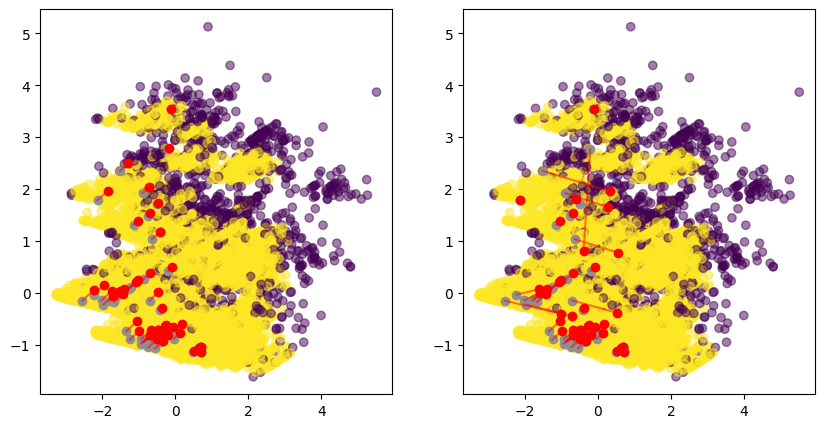

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    axs[i].scatter(X_train_prep[:, 0], X_train_prep[:, 1], c = outlier_detection.predict(X_train), alpha = 0.5)
    #axs[i].scatter(X_train_prep[:, 0], X_train_prep[:, 1], c = "blue", alpha = 0.5)
    axs[i].scatter(individuals_prep[:, 0], individuals_prep[:, 1], c = "#909090")

for i in range(50):
    axs[0].scatter(mapocam_solutions_prep[i, 0], mapocam_solutions_prep[i, 1], c = "red")
    line = np.stack([individuals_prep[i], mapocam_solutions_prep[i]])
    axs[0].plot(line[:, 0], line[:, 1], c = "red", alpha = 0.5)

for i in range(50):
    axs[1].scatter(mapofcem_solutions_prep[i, 0], mapofcem_solutions_prep[i, 1], c = "red")
    line = np.stack([individuals_prep[i], mapofcem_solutions_prep[i]])
    axs[1].plot(line[:, 0], line[:, 1], c = "red", alpha = 0.5)